# Imports and connections

In [22]:
from sqlalchemy import create_engine, text
import pandas as pd
from getpass import getpass
from tqdm.notebook import tqdm
import numpy as np

In [11]:
host = 'test-task-rto.c5qems882moh.ap-southeast-1.rds.amazonaws.com:5432'
user = 'user_test'
database_name = 'postgres'

In [8]:
password = getpass()

 ········


# Data Load

Выгрузим данные для последующих решений через pandas

In [91]:
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}/{database_name}')

In [92]:
query = f'''select  ticket,
                    login,
                    open_time,
                    close_time,
                    symbol,
                    cmd
            from hr_vacancies.mt4_trades mt 
         '''
df_trades_mt4 = pd.read_sql(query, con=engine) 

In [93]:
df_trades_mt4.head(5)

,ticket,login,open_time,close_time,symbol,cmd
0,372752301,290627505,2022-02-03 17:33:01.000000,2022-02-03 17:39:00.000000,EURUSD,0
1,372752584,290627505,2022-02-03 17:34:02.000000,2022-02-03 17:39:00.000000,EURUSD,0
2,372752581,290627505,2022-02-03 17:34:02.000000,2022-02-03 17:39:04.000000,EURUSD,0
3,372752582,290627505,2022-02-03 17:34:02.000000,2022-02-03 17:39:04.000000,EURUSD,0
4,372752586,290627505,2022-02-03 17:34:02.000000,2022-02-03 17:39:04.000000,EURUSD,0


In [94]:
query = f'''
            select *
            from hr_vacancies.mt4_marked_trades
         '''
df_marked_trades_mt4 = pd.read_sql(query, con=engine) 

In [95]:
df_marked_trades_mt4.head(5)

,positionid,type
0,372901954,2
1,372743999,1
2,373053139,2
3,372612581,2
4,372640437,2


# Task №1

**Задание**

*Для каждого пользователя число таких сделок, у которых с момента открытия до момента полного закрытия прошло меньше одной минуты*

## DA for loading

До написания запроса для расчета метрики 1 исследуем соотношение маркированнных сделок в обоих схемах.

Для последующего выбора оптимального пути соединения таблиц и фильтрования маркированных сделок.

In [37]:
tables_names = ['mt4_marked_trades', 'mt5_marked_trades']

with engine.connect() as connection:
    for name_table in tables_names:
        
        query_count_all = f'''SELECT COUNT(*)
                              FROM hr_vacancies.{name_table} mt 
                           ''' # подсчет всех записей в таблице содержащие маркировку
        query_count_marked = f'''SELECT COUNT(*)
                  FROM hr_vacancies.{name_table} mt
                  WHERE (cast(mt."type" as INTEGER)  & 2) = 2;
               ''' # подсчитаем маркированные записи которые необходимо исключить

        
        count_all =  connection.execute(text(query_count_all)).fetchall()[0][0]
        count_marked = connection.execute(text(query_count_marked)).fetchall()[0][0]

        print(f'Schema and table:{name_table}')
        print(f'--All:{count_all}')
        print(f'--Marked:{count_marked}')
        print(f'--UnMarked:{count_all - count_marked}')

Schema and table:mt4_marked_trades
--All:15118
--Marked:7511
--UnMarked:7607
Schema and table:mt5_marked_trades
--All:19921
--Marked:9947
--UnMarked:9974


**Вывод**

Как можно заметить, в обоих случаях количество немаркированных записей слегка превышает количество маркированных, однако отсутствуют дисбаланс классов, что не повлияет сильно на обработку запроса.

При написании запросов для prod. версии -  для всей генеральной совокупности, необходимо будет или иметь больше данных о процессе маркировки сделок, или подсчета статистики для оценки.

На основе предоставленной выборки оставляем запрос на выборку маркированных записей

### Решение через sql

Логика запроса:

1. Подзапросом выбираем все маркированные сделки, фильтруя при помощи побитового умножения на 2
3. Соединяем с данными о сделках по первичному ключу - идентификатору сделки
4. Фильтруем данные по условию времени сделки (меньше минуты) дополнительно исключая записи без даты закрытия, и по отсутствию маркировки (в случае отсутствия даты открытия сработает условие на продолжительность сделки)
5. Группируем данные по пользователю подсчитывая для каждого количество сделок (т.к. каждой сделки соответствует одна, запись делаем обычный COUNT а не COUNT DISTINCT)

In [27]:
a = 4
print(bin(a))
b = 2
print(bin(b))
bin(b & a)

0b100
0b10


'0b0'

In [99]:
query = f'''
            select data_.login,
            	   COUNT(data_.ticket) as count_tickets
            from (
            	select ticket,
            		   login
            	from hr_vacancies.mt4_trades t
            	left join (SELECT positionid, 
            			   1 as marked
            		FROM hr_vacancies.mt4_marked_trades mt 
            		WHERE (cast(mt."type" as INTEGER)  & 2) = 2) mt_filtered
            	on t.ticket = mt_filtered.positionid
            	where open_time < close_time and -- проверка на наличие даты закрытия
            		  cast(t.close_time as timestamp) - cast(t.open_time as timestamp) < interval '1 minute' and 
            		  marked is null 
            	) data_
            group by data_.login
         '''

df_mt4_metric_1_sql = pd.read_sql(query, con=engine) 
df_mt4_metric_1_sql

,login,count_tickets
0,290140265,4
1,290191028,14
2,290415539,145
3,290420240,21
4,290420701,34
...,...,...
184,290678164,122
185,9286519,31
186,9762103,13
187,9762113,14


### решение через pandas

In [102]:
df_mt_4_metric_1 = df_trades_mt4.copy()
df_mt_4_metric_1['open_time'] = pd.to_datetime(df_mt_4_metric_1['open_time'])
df_mt_4_metric_1['close_time'] = pd.to_datetime(df_mt_4_metric_1['close_time'])
df_mt_4_metric_1['time'] = df_mt_4_metric_1['close_time'] - df_mt_4_metric_1['open_time']
df_mt_4_metric_1.head(5)

,ticket,login,open_time,close_time,symbol,cmd,time
0,372752301,290627505,2022-02-03 17:33:01,2022-02-03 17:39:00,EURUSD,0,0 days 00:05:59
1,372752584,290627505,2022-02-03 17:34:02,2022-02-03 17:39:00,EURUSD,0,0 days 00:04:58
2,372752581,290627505,2022-02-03 17:34:02,2022-02-03 17:39:04,EURUSD,0,0 days 00:05:02
3,372752582,290627505,2022-02-03 17:34:02,2022-02-03 17:39:04,EURUSD,0,0 days 00:05:02
4,372752586,290627505,2022-02-03 17:34:02,2022-02-03 17:39:04,EURUSD,0,0 days 00:05:02


In [103]:
df_mt_4_metric_1 = df_mt_4_metric_1[(df_mt_4_metric_1['time'] < pd.Timedelta(minutes=1)) & 
                                    (df_mt_4_metric_1['open_time'] < df_mt_4_metric_1['close_time'])]

df_mt_4_marked_trades = df_marked_trades[(df_marked_trades_mt4['type'].astype(int) & 2) ==2]

df_mt_4_metric_1 = pd.merge(df_mt_4_metric_1, df_mt_4_marked_trades, how = 'left', left_on = 'ticket', right_on = 'positionid')
df_mt_4_metric_1 = df_mt_4_metric_1[df_mt_4_metric_1['type'].isna()]
df_mt_4_metric_1

,ticket,login,open_time,close_time,symbol,cmd,time,positionid,type
0,372753634,290627505,2022-02-03 17:41:03,2022-02-03 17:41:39,EURUSD,0,0 days 00:00:36,NaN,NaN
1,372753635,290627505,2022-02-03 17:41:03,2022-02-03 17:41:39,EURUSD,0,0 days 00:00:36,NaN,NaN
2,372753636,290627505,2022-02-03 17:41:03,2022-02-03 17:41:39,EURUSD,0,0 days 00:00:36,NaN,NaN
3,372762221,290627505,2022-02-03 18:28:04,2022-02-03 18:28:41,EURUSD,0,0 days 00:00:37,NaN,NaN
4,372762222,290627505,2022-02-03 18:28:04,2022-02-03 18:28:41,EURUSD,0,0 days 00:00:37,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5473,372740392,290652685,2022-02-03 16:44:05,2022-02-03 16:44:37,XAUUSD,1,0 days 00:00:32,NaN,NaN
5474,372740628,290652685,2022-02-03 16:44:40,2022-02-03 16:45:09,XAUUSD,1,0 days 00:00:29,NaN,NaN
5475,372741350,290652685,2022-02-03 16:45:13,2022-02-03 16:45:18,XAUUSD,1,0 days 00:00:05,NaN,NaN
5476,372741403,290652685,2022-02-03 16:45:21,2022-02-03 16:45:31,XAUUSD,1,0 days 00:00:10,NaN,NaN


In [104]:
df_mt_4_metric_1 = df_mt_4_metric_1.groupby(by='login',as_index = False)['ticket'].count()
df_mt_4_metric_1 = df_mt_4_metric_1.rename(columns = {'ticket':'count_tickets'})
df_mt_4_metric_1

,login,count_tickets
0,290140265,4
1,290191028,14
2,290415539,145
3,290420240,21
4,290420701,34
...,...,...
184,290678164,122
185,9286519,31
186,9762103,13
187,9762113,14


### Сравнение результатов

In [105]:
(df_mt4_metric_1_sql == df_mt_4_metric_1).sum()

login            189
count_tickets    189
dtype: int64

Все строки совпали

In [106]:
df_mt_4_metric_1.shape[0]

189

# Task №2

**Задание**

*Для каждого пользователя найти число таких пар сделок, которые удовлетворяют следующим условиям:*
1. *Сделки совершены этим пользователем*
2. *Разница между временем их открытия не более 30 секунд*
3. *Направление этих сделок – противоположное (одна на покупку, другая напродажу)*

## решение через pandas

In [353]:
df_mt_4_metric_2 = df_trades_mt4.copy()
df_mt_4_metric_2['open_time'] = pd.to_datetime(df_mt_4_metric_2['open_time'])
df_mt_4_metric_2 = df_mt_4_metric_2[df_mt_4_metric_2['open_time'].dt.year != 1970] # т.к. ориентируемся на дату открытия то убираем отсутствующие значения
df_mt_4_metric_2 = pd.merge(df_mt_4_metric_2, df_mt_4_marked_trades, how = 'left', left_on = 'ticket', right_on = 'positionid')
df_mt_4_metric_2 = df_mt_4_metric_2[df_mt_4_metric_2['type'].isna()]
df_mt_4_metric_2.head(5)

,ticket,login,open_time,close_time,symbol,cmd,positionid,type
0,372752301,290627505,2022-02-03 17:33:01,2022-02-03 17:39:00.000000,EURUSD,0,NaN,NaN
1,372752584,290627505,2022-02-03 17:34:02,2022-02-03 17:39:00.000000,EURUSD,0,NaN,NaN
2,372752581,290627505,2022-02-03 17:34:02,2022-02-03 17:39:04.000000,EURUSD,0,NaN,NaN
3,372752582,290627505,2022-02-03 17:34:02,2022-02-03 17:39:04.000000,EURUSD,0,NaN,NaN
4,372752586,290627505,2022-02-03 17:34:02,2022-02-03 17:39:04.000000,EURUSD,0,NaN,NaN


Основная логика решения:

1. Делаем как индекс датафрейма дату открытия
2. Группируя по пользователю проходим оконной функцией с окном в 30 секунд
3. В каждом окне подсчитываем количество сделок каждого из направлений
4. Перемножаем их получая количество всевозможных пар сделок в окне разной направленности
5. Суммируем подсчитанные пары для каждого пользователя

In [355]:
def check_opposite_trades(x):
    res = x.value_counts()
    if res.shape[0] > 1: # если есть 1 и 0 то все пары это их перемноженное кол-во
        return res.iloc[0] * res.iloc[1]
    return 0 
    
def check_metric_2(df_user: pd.DataFrame):
    df_user = df_user.sort_index() # для применения оконной функции индекс должен возрастать
    return df_user.rolling('30s', min_periods=2)['cmd'].apply(check_opposite_trades).sum() # оконная функция в 30 секунд включительно
    
df_mt_4_metric_2 = df_mt_4_metric_2.set_index('open_time')
df_mt_4_metric_2 = df_mt_4_metric_2[['login','cmd']].groupby(by='login', as_index = False).apply(check_metric_2)
df_mt_4_metric_2

/var/folders/nf/rd32kdyn0j9fz___z5xdz_q40000gn/T/ipykernel_8483/4110183580.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mt_4_metric_2 = df_mt_4_metric_2[['login','cmd']].groupby(by='login', as_index = False).apply(check_metric_2)


,login,None
0,290140265,13.0
1,290179144,0.0
2,290191028,0.0
3,290389398,0.0
4,290415539,28.0
...,...,...
194,290678164,138.0
195,9286519,148.0
196,9762103,158.0
197,9762113,155.0


In [361]:
df_mt_4_metric_2 = df_mt_4_metric_2.rename(columns = {df_mt_4_metric_2.columns[1]:'metric_2'})
df_mt_4_metric_2

,login,metric_2
0,290140265,13.0
1,290179144,0.0
2,290191028,0.0
3,290389398,0.0
4,290415539,28.0
...,...,...
194,290678164,138.0
195,9286519,148.0
196,9762103,158.0
197,9762113,155.0


### Проверка и отладка функций на синтетических данных

При написании, было замечено что одна из предыдущих функция работает неправильно из-за возвращения value_counts pd.Series с индексом во float.

Производил проверку и отладку на синтетических данных, чтобы убедиться что в коде проблемы 

Сейчас все хорошо

In [ ]:
# df_buf = df_buf.set_index('open_time')
# df_buf = df_buf.sort_index()
# df_buf['cmd'] = df_buf['cmd'].astype(int)
# df_buf.rolling('30s', min_periods=2)['cmd'].apply(check_opposite_trades).sum()

In [357]:
# df_buf_2 = pd.DataFrame(df_buf.iloc[-1]).transpose() # создадим вымышленную транзакцию
# df_buf_2 = df_buf_2.set_index(pd.Series([df_buf.index[-1] + pd.Timedelta(seconds = 5)]))
# df_buf_2['cmd'] = abs(df_buf['cmd'].values[-1] - 1) # |1 - 1 = 0| or |0 - 1| = 1
# df_buf_2

In [358]:
# df_buf = pd.concat([df_buf, df_buf_2]) # добавим новую запись
# df_buf
#df_buf[['login','cmd']].groupby(by='login', as_index = False).apply(check_metric_2)

# Сохранение результатов mt-4 metric-1, metric-2

In [371]:
df_res = pd.merge(df_trades_mt4[['login']].drop_duplicates(), df_mt_4_metric_1, how='left', on='login')
df_res = pd.merge(df_res, df_mt_4_metric_2, how='left', on='login')
df_res = df_res.rename(columns = {'count_tickets':'metric_1'})

In [370]:
df_res.isna().sum()

login             0
count_tickets    10
metric_2          0
dtype: int64

In [372]:
df_res.to_csv('mt_4_metrics_1_2.csv')

# Task № 3 

**Задание**

*Мысленно разобьем все время на равные промежутки по 30 секунд. Найти среди всех
возможных пар пользователей такие, у которых более 10 сделок удовлетворяют условиям:*
1. *Открытия сделок попали в один промежуток времени*
2. *Они открыты по одному и тому же инструменту*
3. *Они принадлежат разным пользователям (одна одному пользователю из пары,
другая другому)*
4. *Они открыты в разных направлениях (одна на покупку, другая на продажу)*

## решение через pandas

Для начала подсчитаем для каждого пользователя количество сделок каждого из конкретных направлений

In [531]:
df_mt_4_metric_3 = df_trades_mt4.copy()
df_mt_4_metric_3['open_time'] = pd.to_datetime(df_mt_4_metric_3['open_time'])
df_mt_4_metric_3 = df_mt_4_metric_3[df_mt_4_metric_3['open_time'].dt.year != 1970]
df_mt_4_metric_3 = pd.merge(df_mt_4_metric_3,
                            df_mt_4_marked_trades,
                            how = 'left',
                            left_on = 'ticket',
                            right_on = 'positionid')
df_mt_4_metric_3 = df_mt_4_metric_3[df_mt_4_metric_3['type'].isna()]
df_mt_4_metric_3['cmd'] = df_mt_4_metric_3['cmd'].astype(int)
df_mt_4_metric_3.head(5)

,ticket,login,open_time,close_time,symbol,cmd,positionid,type
0,372752301,290627505,2022-02-03 17:33:01,2022-02-03 17:39:00.000000,EURUSD,0,NaN,NaN
1,372752584,290627505,2022-02-03 17:34:02,2022-02-03 17:39:00.000000,EURUSD,0,NaN,NaN
2,372752581,290627505,2022-02-03 17:34:02,2022-02-03 17:39:04.000000,EURUSD,0,NaN,NaN
3,372752582,290627505,2022-02-03 17:34:02,2022-02-03 17:39:04.000000,EURUSD,0,NaN,NaN
4,372752586,290627505,2022-02-03 17:34:02,2022-02-03 17:39:04.000000,EURUSD,0,NaN,NaN


In [532]:
windows_boundaries = pd.date_range(pd.to_datetime('2022-02-01 00:00:00'),
                                   pd.to_datetime('2022-02-08 00:00:00'),
                                   freq=pd.Timedelta(seconds=30))

# будем использовать правую границу окна
df_mt_4_metric_3['right_boundary'] = pd.cut(df_mt_4_metric_3['open_time'], windows_boundaries).apply(lambda x: x.right) 
df_mt_4_metric_3

,ticket,login,open_time,close_time,symbol,cmd,positionid,type,right_boundary
0,372752301,290627505,2022-02-03 17:33:01,2022-02-03 17:39:00.000000,EURUSD,0,NaN,NaN,2022-02-03 17:33:30
1,372752584,290627505,2022-02-03 17:34:02,2022-02-03 17:39:00.000000,EURUSD,0,NaN,NaN,2022-02-03 17:34:30
2,372752581,290627505,2022-02-03 17:34:02,2022-02-03 17:39:04.000000,EURUSD,0,NaN,NaN,2022-02-03 17:34:30
3,372752582,290627505,2022-02-03 17:34:02,2022-02-03 17:39:04.000000,EURUSD,0,NaN,NaN,2022-02-03 17:34:30
4,372752586,290627505,2022-02-03 17:34:02,2022-02-03 17:39:04.000000,EURUSD,0,NaN,NaN,2022-02-03 17:34:30
...,...,...,...,...,...,...,...,...,...
265634,372727735,290652685,2022-02-03 16:01:00,2022-02-11 21:02:11.000000,EURUSD,1,NaN,NaN,2022-02-03 16:01:00
265635,373022961,290652685,2022-02-07 17:22:32,2022-02-08 09:21:30.000000,XAUUSD,1,NaN,NaN,2022-02-07 17:23:00
265636,373034944,290652685,2022-02-07 18:33:19,2022-02-08 09:21:30.000000,XAUUSD,1,NaN,NaN,2022-02-07 18:33:30
265637,372737533,290652685,2022-02-03 16:36:01,2022-02-11 20:46:19.000000,EURJPY,1,NaN,NaN,2022-02-03 16:36:30


In [533]:
def count_trades_in_window(x):
    res = x.value_counts()
    res.index = res.index.astype(int)
    return res.to_dict()

df_mt_4_metric_3 = df_mt_4_metric_3[['login','symbol','cmd', 'right_boundary']]
df_mt_4_metric_3 = df_mt_4_metric_3.groupby(by=['login','symbol','right_boundary'],
                                            observed = True,
                                            as_index = False)['cmd'].apply(count_trades_in_window).reset_index()
df_mt_4_metric_3

,login,symbol,right_boundary,level_3,cmd
0,290140265,AUDCAD,2022-02-01 16:31:30,1,1.0
1,290140265,AUDCAD,2022-02-01 16:31:30,0,NaN
2,290140265,AUDCAD,2022-02-02 01:27:00,1,1.0
3,290140265,AUDCAD,2022-02-02 01:27:00,0,NaN
4,290140265,AUDCAD,2022-02-02 02:56:30,1,1.0
...,...,...,...,...,...
418945,9826480,EURUSD,2022-02-07 21:33:00,0,NaN
418946,9826480,EURUSD,2022-02-07 21:47:30,1,2.0
418947,9826480,EURUSD,2022-02-07 21:47:30,0,NaN
418948,9826480,EURUSD,2022-02-07 21:59:30,1,2.0


In [534]:
df_mt_4_metric_3 = df_mt_4_metric_3.rename(columns = {'cmd':'trades_count',
                                                      df_mt_4_metric_3.columns[3]:'cmd'})
df_mt_4_metric_3

,login,symbol,right_boundary,cmd,trades_count
0,290140265,AUDCAD,2022-02-01 16:31:30,1,1.0
1,290140265,AUDCAD,2022-02-01 16:31:30,0,NaN
2,290140265,AUDCAD,2022-02-02 01:27:00,1,1.0
3,290140265,AUDCAD,2022-02-02 01:27:00,0,NaN
4,290140265,AUDCAD,2022-02-02 02:56:30,1,1.0
...,...,...,...,...,...
418945,9826480,EURUSD,2022-02-07 21:33:00,0,NaN
418946,9826480,EURUSD,2022-02-07 21:47:30,1,2.0
418947,9826480,EURUSD,2022-02-07 21:47:30,0,NaN
418948,9826480,EURUSD,2022-02-07 21:59:30,1,2.0


In [535]:
df_mt_4_metric_3 = df_mt_4_metric_3.dropna() # уменьшим количество операций для последующей предобработки
df_mt_4_metric_3

,login,symbol,right_boundary,cmd,trades_count
0,290140265,AUDCAD,2022-02-01 16:31:30,1,1.0
2,290140265,AUDCAD,2022-02-02 01:27:00,1,1.0
4,290140265,AUDCAD,2022-02-02 02:56:30,1,1.0
6,290140265,AUDCAD,2022-02-02 12:57:30,1,1.0
8,290140265,AUDJPY,2022-02-01 22:49:00,1,1.0
...,...,...,...,...,...
418942,9826480,EURUSD,2022-02-07 21:12:00,1,2.0
418943,9826480,EURUSD,2022-02-07 21:12:00,0,2.0
418944,9826480,EURUSD,2022-02-07 21:33:00,1,2.0
418946,9826480,EURUSD,2022-02-07 21:47:30,1,2.0


Далее полученных датафрейм преобразуем в тензор следующего вида:

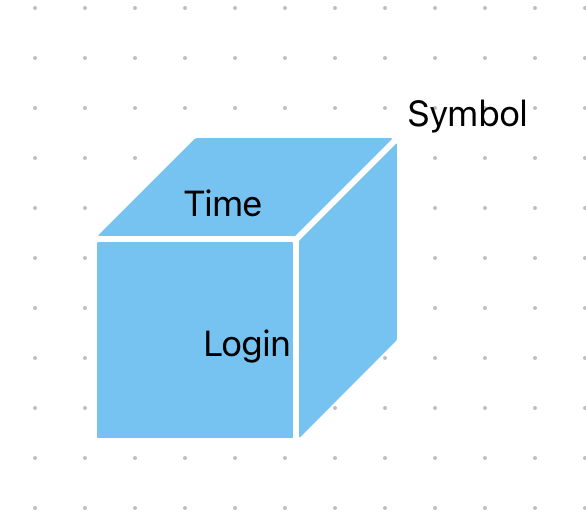


При этом важно чтобы каждый конкретная позиция индекса отвечала за определенного пользователя или момент времени, а также продукт

In [536]:
cmd = 0
dfs_cmd_0 = []
for product in tqdm(df_mt_4_metric_3['symbol'].unique()): # для каждого продукта
    df_cmd_0 = pd.DataFrame(index = df_trades_mt4['login'].unique(), columns = windows_boundaries) # создаем матрицу где индекс пользователь а колонки время
    for user in df_trades_mt4['login'].unique(): # заполняем каждую строку такой матрицы
        user_product = df_mt_4_metric_3[(df_mt_4_metric_3['login'] == user) & 
                                        (df_mt_4_metric_3['symbol'] == product) &
                                        (df_mt_4_metric_3['cmd'] == cmd)]
        df_cmd_0.loc[user, user_product['right_boundary'].values] = user_product['trades_count'].values
        
    df_cmd_0 = df_cmd_0.fillna(0) 
    dfs_cmd_0.append(df_cmd_0.values)

len(dfs_cmd_0)

  0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/nf/rd32kdyn0j9fz___z5xdz_q40000gn/T/ipykernel_8483/2817924450.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cmd_0 = df_cmd_0.fillna(0)
/var/folders/nf/rd32kdyn0j9fz___z5xdz_q40000gn/T/ipykernel_8483/2817924450.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cmd_0 = df_cmd_0.fillna(0)
/var/folders/nf/rd32kdyn0j9fz___z5xdz_q40000gn/T/ipykernel_8483/2817924450.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False)

30

Можно было попробовать сделать через модификации датафрейма, однако в таком случае мы не будем уверены что на конкретных строках пользователи а в колонках соответствующие даты в разных матрицах (cmd = 0 и cmd = 1) т.к. при фильтрации не гарантируется что у всех пользователей были и продажи и покупки по всем продуктам во все временные промежутки

Поэтому приходится жертвовать временем на предобработке

Делаем то же самое только теперь для cmd = 1

In [537]:

cmd = 1
dfs_cmd_1 = []
for product in tqdm(df_mt_4_metric_3['symbol'].unique()): # для каждого продукта
    df_cmd_1 = pd.DataFrame(index = df_trades_mt4['login'].unique(), columns = windows_boundaries) # создаем матрицу где индекс пользователь а колонки время
    for user in df_trades_mt4['login'].unique(): # заполняем каждую строку такой матрицы
        user_product = df_mt_4_metric_3[(df_mt_4_metric_3['login'] == user) & 
                                        (df_mt_4_metric_3['symbol'] == product) &
                                        (df_mt_4_metric_3['cmd'] == cmd)]
        df_cmd_1.loc[user, user_product['right_boundary'].values] = user_product['trades_count'].values
        
    df_cmd_1 = df_cmd_1.fillna(0) 
    dfs_cmd_1.append(df_cmd_1.values)

len(dfs_cmd_1)

  0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/nf/rd32kdyn0j9fz___z5xdz_q40000gn/T/ipykernel_8483/571415037.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cmd_1 = df_cmd_1.fillna(0)
/var/folders/nf/rd32kdyn0j9fz___z5xdz_q40000gn/T/ipykernel_8483/571415037.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cmd_1 = df_cmd_1.fillna(0)
/var/folders/nf/rd32kdyn0j9fz___z5xdz_q40000gn/T/ipykernel_8483/571415037.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) in

30

Таким образом получаем два тензора в которых:
1. первая ось - клиенты
2. вторая ось - время
3. третья ось - продукты

In [542]:

tensor_cmd_1 = np.dstack(dfs_cmd_1)
tensor_cmd_0 = np.dstack(dfs_cmd_0)
tensor_cmd_1.shape, tensor_cmd_0.shape

((199, 20161, 30), (199, 20161, 30))

Далее преобразуем формы тензоров, чтобы на выходе получить тензор формы (30, 199, 199)

При этом транспонируем второй тензор так чтобы при матричном перемножении строка отвечающая за пользователя умножалась на столбец отвечающий за пользователя

Таким образом после такого перемножения получим что по всем продуктам, будем иметь количество пар сделок которые были произведены в одно время с разной направленностью (т.к. в предыдущей ячейке разделили тензоры по cmd)

Далее просуммировав по продуктам получим матрицу пользователь - пользователь

Идея решения представлена ниже

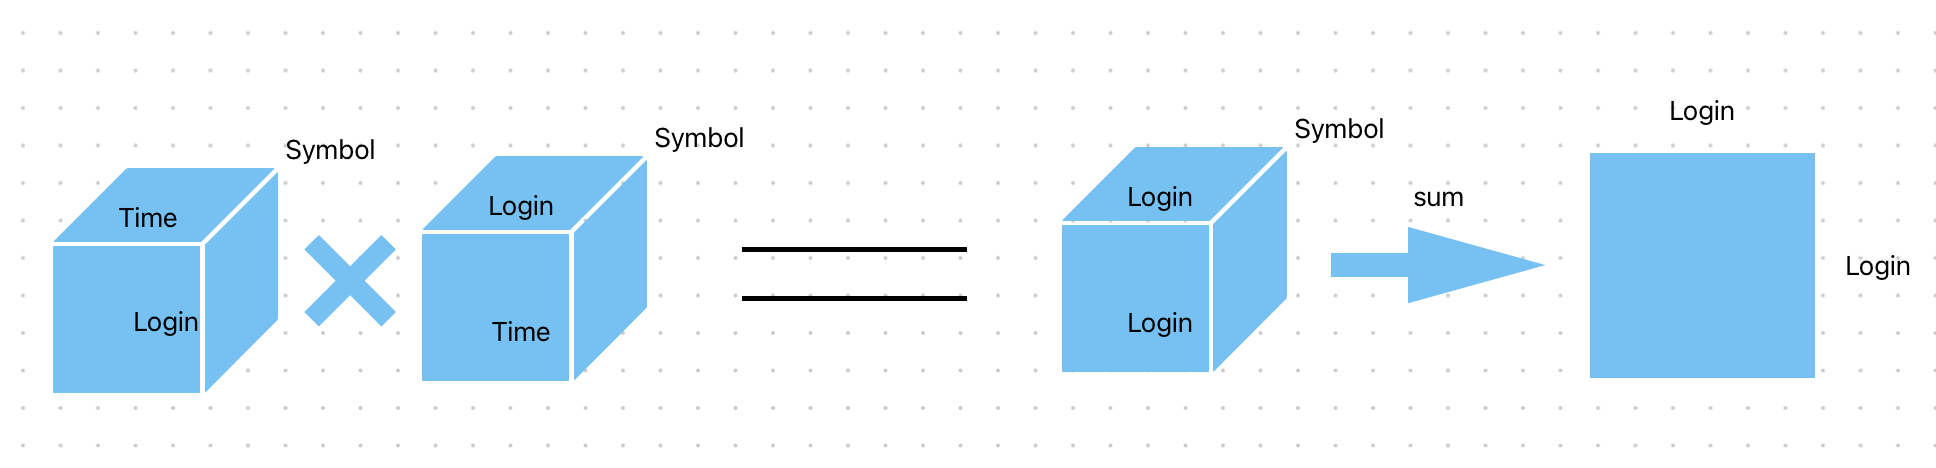

In [568]:
tensor_cmd_0 = np.transpose(tensor_cmd_0, (2, 0, 1))  
tensor_cmd_1 = np.transpose(tensor_cmd_1, (2, 1, 0))  

result = np.matmul(tensor_cmd_0, tensor_cmd_1)

result

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0.

In [569]:
result.shape

(30, 199, 199)

Просуммируем по всем продуктам полученное количество пар сделок

In [573]:
result = np.sum(result, axis=0)
result.shape

(199, 199)

установим на диагонали нули т.к. хотим рассматривать случае только если пользователи не являются одним человеком

In [583]:
result[np.diag_indices(result.shape[0])] = 0
result


array([[   0., 2986., 3988., ...,   58.,    0.,   43.],
       [2799.,    0., 1173., ...,   21.,    0.,   33.],
       [3805., 1269.,    0., ...,   18.,    0.,   15.],
       ...,
       [ 118.,   56.,   43., ...,    0.,    0.,   48.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,   35.,    0.,    0.]])

Создадим датафрейм и отфильтруемся по количеству сделок

In [598]:
users = df_trades_mt4['login'].unique()

indexes_users = np.where(result > 10)
df_task_3 = pd.DataFrame(columns = ['user_1','user_2'])
df_task_3['user_1'] = [users[i] for i  in indexes_users[0]]
df_task_3['user_2'] = [users[i] for i  in indexes_users[1]]
df_task_3

,user_1,user_2
0,290627505,290603503
1,290627505,290675276
2,290627505,290630765
3,290627505,290650470
4,290627505,290569408
...,...,...
22388,290652685,290646066
22389,290652685,290507690
22390,290652685,290585680
22391,290652685,290635108


In [601]:
df_task_3.to_csv('mt_4_metrics_3.csv')